# Analyse des sentiments - Rétroaction des produits et innovations

### Importation des librairies

In [1]:
# Importation des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex  import NRCLex
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Téléchargement des autres packages
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\HP ELITEBOOK 840
[nltk_data]     G6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Importation des avis sur les produits

In [3]:
# Importation de la base de données
commentaires = pd.read_csv(r"D:\Projets\IT\Datascience\datascience\nlp\sentiment_analyse\avis_consommateurs.csv")
commentaires


,Avis
0,Les mises à jour logicielles apportent souvent...
1,L'EcoHome Assistant ne reconnaît pas toujours ...
2,J'apprécie les notifications personnalisées po...
3,J'apprécie les notifications personnalisées po...
4,"J'aime l'idée, mais j'ai rencontré des bugs fr..."
...,...
495,Les suggestions personnalisées sont vraiment u...
496,Les suggestions personnalisées sont vraiment u...
497,Les recommandations pour économiser l'eau sont...
498,"J'aime l'idée, mais j'ai rencontré des bugs fr..."


## Pré-traitement des données textuelles
### Tokenization

In [4]:
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Application de la fonction sur les données textuelles
commentaires['tokens']=commentaires['Avis'].apply(tokenize)

### Supression des stopwords

In [5]:
def remove_stopword(tokens, stop_word):
    stopwords = [word for word in tokens if word not in stop_word]
    return stopwords

# Choix des mots à supprimer
stop_word = ["le", "la", "les", "de", "des", "et", "en", "un", "une", "c", "est",'j','l','sont','que','ai']

# Application de la fonction
commentaires['stopword']= commentaires['tokens'].apply(lambda tokens : remove_stopword(tokens, stop_word))

### Lemmatization

In [17]:
# Initialisation du modèle de lemme
lemmatizer = WordNetLemmatizer()

def lemme_token(tokens):
    lemme = [lemmatizer.lemmatize(token)for token in tokens]
    return lemme

# Application de la fontion
commentaires['lemmatized'] = commentaires['stopword'].apply(lemme_token)

# Conversion des lemmes en phrases
commentaires['lemmatized_text']= commentaires['lemmatized'].apply(lambda x: ' '.join(x))

## Mesure de l'importance des termes avec le TF -IDF

In [18]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(commentaires['lemmatized_text'])

# Extraction des termes et des scores
termes = tfidf.get_feature_names_out()
scores = tfidf_matrix.toarray()

# Convertir en DataFrame
data_tf = pd.DataFrame(scores, columns=termes)
data_tf= data_tf.max().reset_index()
data_tf.columns=["Termes", 'Scores']

# Choix des 10 meilleurs termes
data_tf = data_tf.sort_values(by='Scores', ascending=False).head(10)
data_tf


,Termes,Scores
77,utiles,0.543370
74,suggestion,0.543370
25,eau,0.476367
82,économiser,0.476367
28,excellentes,0.476367
3,améliorée,0.476224
6,application,0.476224
48,mobile,0.476224
56,personnalisées,0.454421
80,vraiment,0.450554


## Visualisation graphique des termes importants

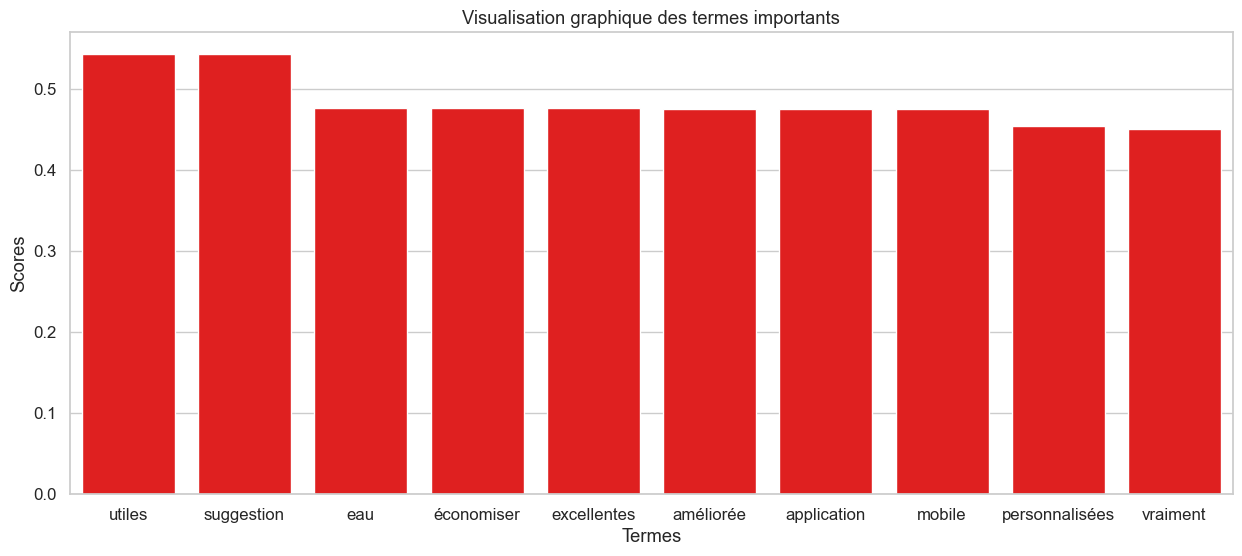

In [22]:
sns.set(style='whitegrid', palette='deep', font_scale=1.1)
plt.figure(figsize=(15,6))
sns.barplot(x='Termes',y='Scores',data=data_tf, color='red')
plt.title('Visualisation graphique des termes importants')
plt.show()

## Sentiment Analysis - VADER Model

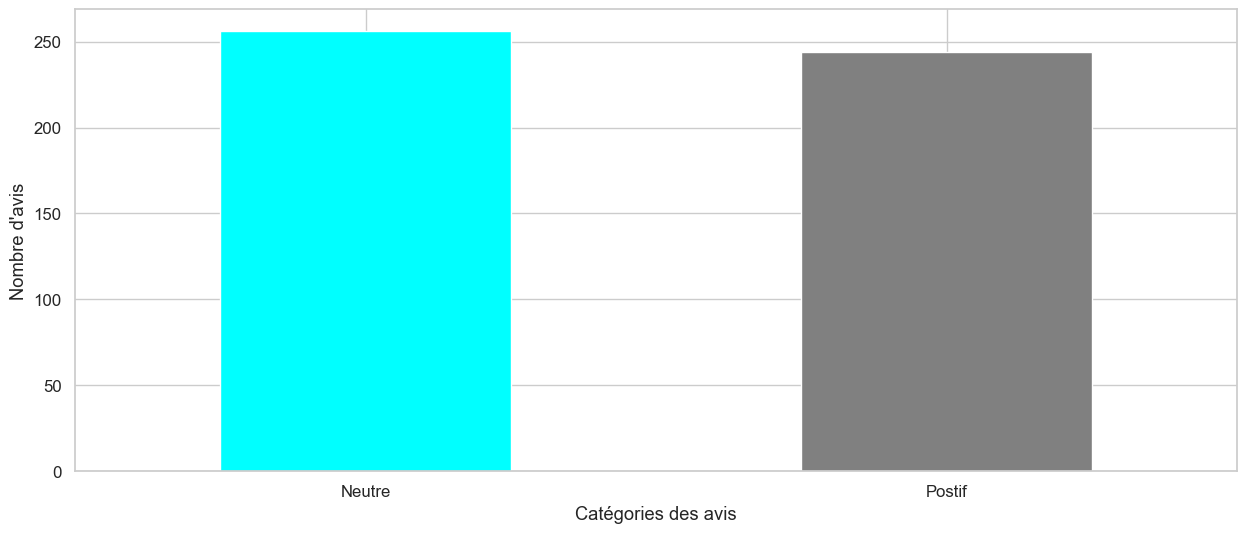

In [26]:
sentimental = SentimentIntensityAnalyzer()
def sentiment_analyze(text):
    sentiment = sentimental.polarity_scores(text)
    return sentiment['compound']
commentaires["stopword"]= commentaires['tokens'].apply(lambda y : ' '.join(y))
commentaires['polarity']= commentaires["stopword"].apply(sentiment_analyze)

# Interprétation de l'analyse de sentiment
def interpretation(polarity):
    if polarity > 0.05:
        return 'Postif'
    elif polarity < -0.05:
        return 'Négatif'
    else :
        return 'Neutre'

commentaires['interpret']= commentaires['polarity'].apply(interpretation)

# Visualisation graphique 
count_value = commentaires['interpret'].value_counts()
plt.figure(figsize=(15,6))
count_value.plot(kind='bar', color=['cyan','gray','skyblue'])
plt.xlabel('Catégories des avis')
plt.ylabel("Nombre d'avis")
plt.xticks(rotation=0)
plt.show()

## Modélisations des sujets avec LDA

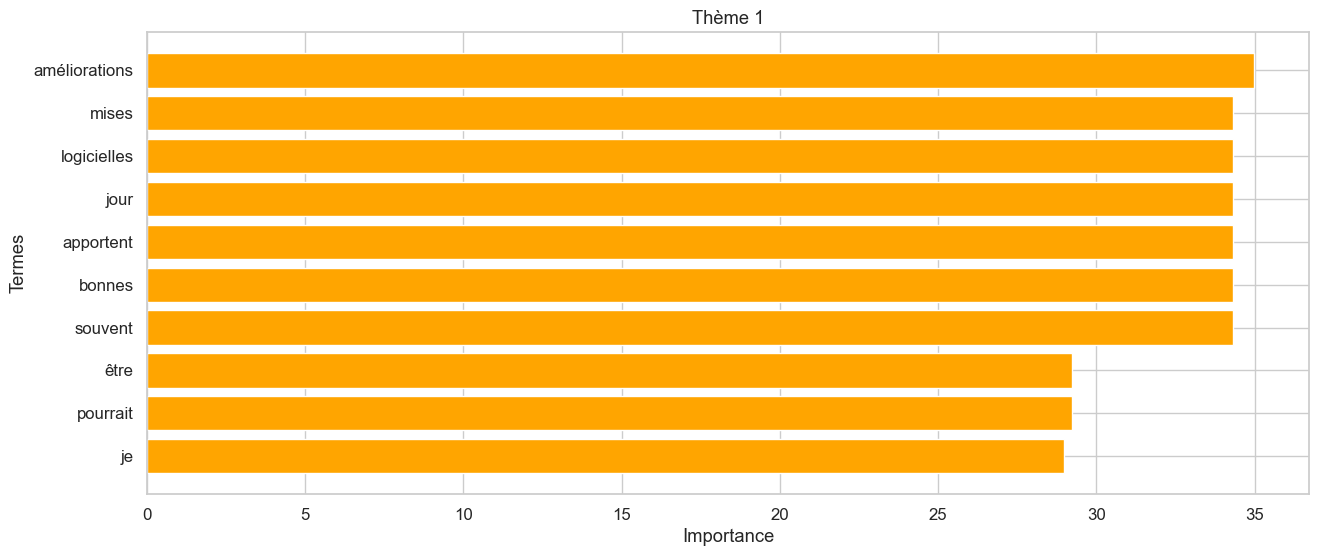

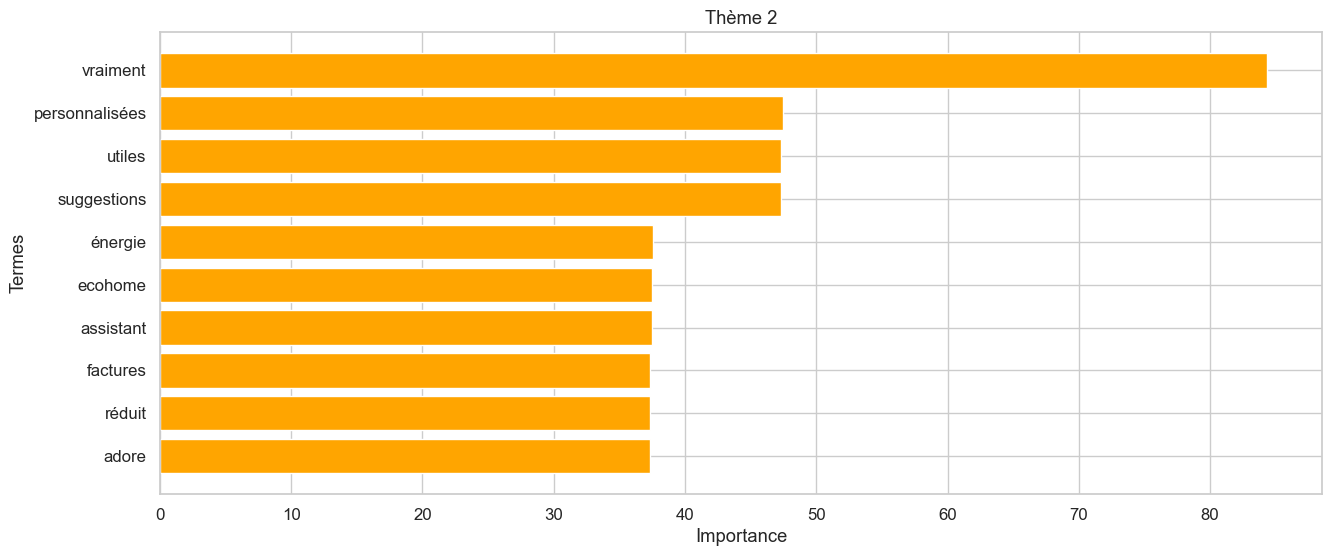

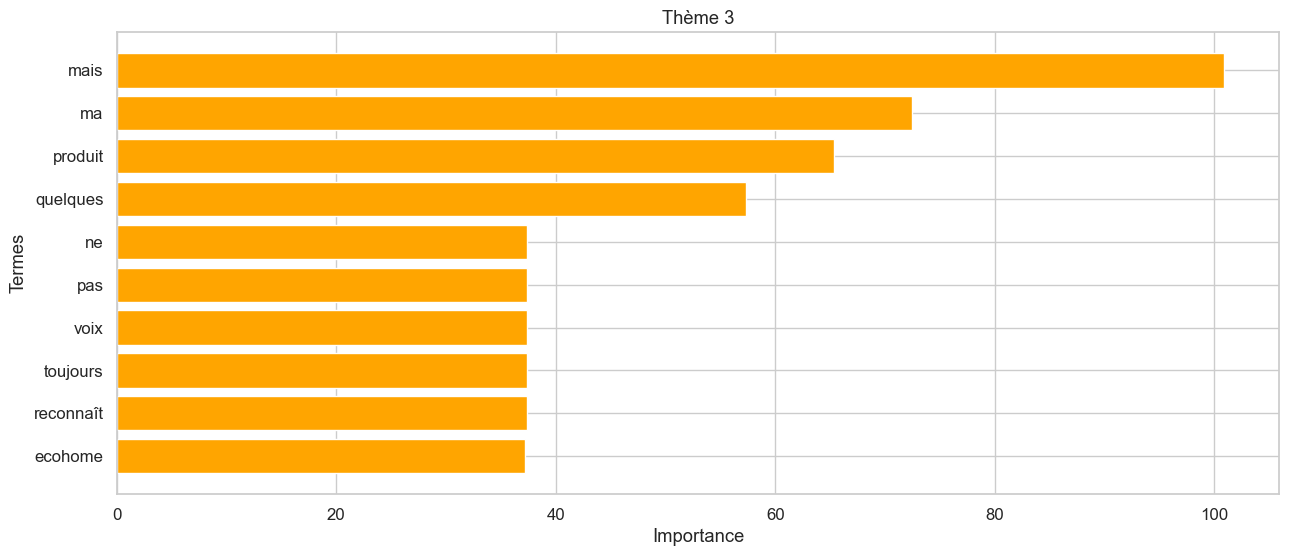

In [32]:
# Vectorisation des avis pour LDA
count_vectorizer = CountVectorizer(stop_words=stop_word, max_features=1000)
count_matrix = count_vectorizer.fit_transform(commentaires['stopword'])

# Modèle LDA
lda = LDA(n_components=3, random_state=42)
lda.fit(count_matrix)

# Extraction des termes
termes = count_vectorizer.get_feature_names_out()

# Graphique des thèmes (poids des mots)
for idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:]
    plt.figure(figsize=(15, 6))
    plt.barh([termes[i] for i in top_indices], topic[top_indices], color='orange')
    plt.title(f"Thème {idx + 1}")
    plt.xlabel("Importance")
    plt.ylabel("Termes")
    plt.show()

## Analyse des émotions

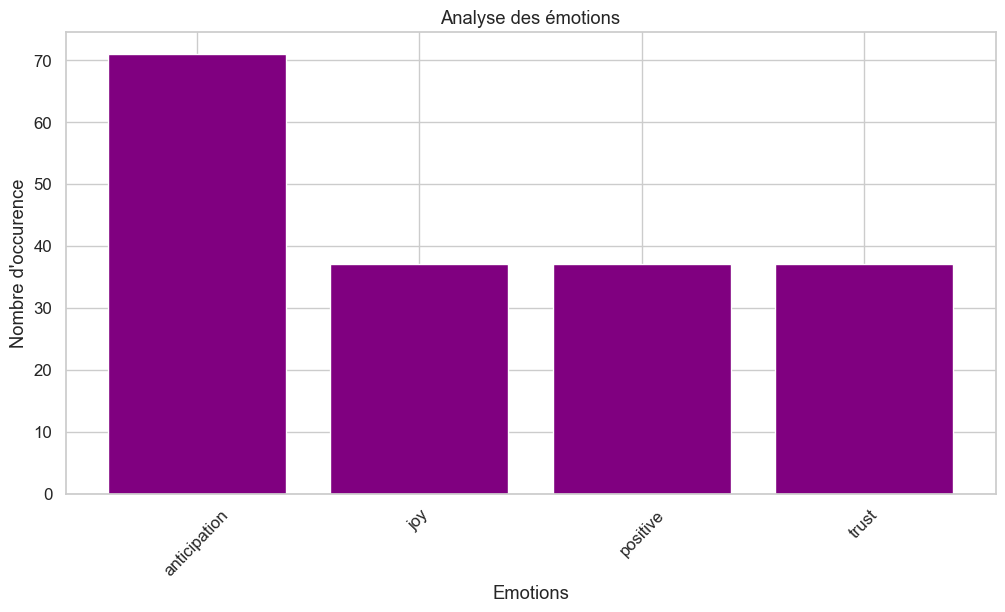

In [36]:
def analyze_emotion(text):
    emotions = NRCLex(text)
    return emotions.raw_emotion_scores

# Application sur les avis 
commentaires['emotion']= commentaires['stopword'].apply(analyze_emotion)

# Agrégation des émotions
emotion_count =Counter()
for emotions in commentaires['emotion']:
    emotion_count.update(emotions)

# Visualisation des émotions
plt.figure(figsize=(12,6))
plt.bar(emotion_count.keys(), emotion_count.values(), color='purple')
plt.xlabel('Emotions')
plt.ylabel("Nombre d'occurence")
plt.title("Analyse des émotions")
plt.xticks(rotation=46)
plt.show()